In [7]:
import numpy as np
import matplotlib.pyplot as plt  # Add this import
from maze import Maze
from DQNAgent import DQNAgent
from rl_evaluator import RLEvaluator, run_comparison  # Add this import
import torch

In [8]:
# Constants
GAME_HEIGHT = 125
GAME_WIDTH = 125
NUMBER_OF_TILES = 9
SCREEN_HEIGHT = 700
SCREEN_WIDTH = 700
TILE_SIZE = GAME_HEIGHT // NUMBER_OF_TILES

# Maze layout
level = [
    "XXXXXXXXXXXXX",
    "X           X",
    "X XXX X XXX X",
    "X   X X   X X",
    "XXX X XXX X X",
    "X   X   X   X",
    "X XXX XXX X X",
    "X X   X   X X",
    "X XXX X XXX X",
    "X   X X   X X",
    "XXX XXX XXX X",
    "XP        X X",
    "XXXXXXXXXXXXX",
]

env = Maze(level, goal_pos=(1, 5), MAZE_HEIGHT=GAME_HEIGHT, MAZE_WIDTH=GAME_WIDTH, SIZE=TILE_SIZE)

# Define state and action dimensions based on your environment's needs
state_dim = 2  # Assuming the state is a 2D coordinate (row, col)
action_dim = 4  # Four actions: left, up, right, down
agent = DQNAgent(state_dim, action_dim)

In [9]:
# Add evaluation function
def evaluate_agent(env, agent, num_runs=5):
    total_reward = 0
    for _ in range(num_runs):
        state = env.reset_state()
        done = False
        episode_reward = 0
        while not done:
            action = agent.get_action(state, 0.1)  # No exploration
            next_state, reward, done = env.step(action)
            episode_reward += reward
            state = next_state
        total_reward += episode_reward
    average_reward = total_reward / num_runs
    return average_reward


def plot_path(agent_path, episode, max_steps=100):
    grid = np.zeros((env.number_of_tiles, env.number_of_tiles))
    for (row, col) in env.walls:
        grid[row, col] = -1  # Represent walls with -1
    for step, (row, col) in enumerate(agent_path[:max_steps]):
        grid[row, col] = step + 1  # Mark path with step number
    grid[env.goal_pos] = 10  # Mark goal with 10
    plt.figure(figsize=(env.number_of_tiles, env.number_of_tiles))  # Adjust figure size to match maze size
    plt.imshow(grid, cmap="viridis", origin="upper")
    plt.colorbar(label="Steps (0=start, 10=goal)")
    plt.title(f"Path Taken by Agent - Episode {episode}")
    plt.show()

# Initialize lists to store rewards and losses
episode_rewards = []
episode_losses = []

# Training loop
num_episodes = 150
evaluation_interval = 50  # Evaluate every 50 episodes
for episode in range(num_episodes):
    state = env.reset_state()
    done = False
    steps = 0
    cumulative_loss = 0
    episode_reward = 0
    agent_path = [state]  # Track path for visualization

    while not done:
        action = agent.get_action(state, 0.1)
        next_state, reward, done = env.step(action)
        agent.store_transition(state, action, reward, next_state, done)
        loss = agent.train()
        cumulative_loss += loss
        episode_reward += reward
        steps += 1
        state = next_state
        agent_path.append(state)  # Add to path

    avg_loss = cumulative_loss / steps if steps > 0 else 0
    episode_rewards.append(episode_reward)  # Store total reward
    episode_losses.append(avg_loss)         # Store average loss

    # Print episode details
    print(f"Episode {episode} completed with {steps} steps, average loss {avg_loss} and total reward {episode_reward}")

    # Evaluate the agent and plot path every 50 episodes
    #if episode % evaluation_interval == 0 and episode != 0:
        #avg_reward = evaluate_agent(env, agent)
        #print(f"Evaluation after episode {episode}: Average Reward = {avg_reward}")
    if episode_reward > 50:
        plot_path(agent_path, episode)

# After training, plot rewards and losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.subplot(1, 2, 2)
plt.plot(episode_losses)
plt.title('Average Loss per Episode')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from maze import Maze
from DQNAgent import DQNAgent
import torch

# Constants
GAME_HEIGHT = 125
GAME_WIDTH = 125
NUMBER_OF_TILES = 9
TILE_SIZE = GAME_HEIGHT // NUMBER_OF_TILES

# Maze layout
level = [
    "XXXXXXXXXXXXX",
    "X           X",
    "X XXX X XXX X",
    "X   X X   X X",
    "XXX X XXX X X",
    "X   X   X   X",
    "X XXX XXX X X",
    "X X   X   X X",
    "X XXX X XXX X",
    "X   X X   X X",
    "XXX XXX XXX X",
    "XP        X X",
    "XXXXXXXXXXXXX",
]

env = Maze(level, goal_pos=(1, 5), MAZE_HEIGHT=GAME_HEIGHT, MAZE_WIDTH=GAME_WIDTH, SIZE=TILE_SIZE)

# Define state and action dimensions
state_dim = 2
action_dim = 4
agent = DQNAgent(state_dim, action_dim)

# Initialize variables to track rewards
rewards_over_time = []
arm_rewards_over_time = {i: [] for i in range(action_dim)}

# Training loop
num_episodes = 100
for episode in range(num_episodes):
    state = env.reset_state()
    done = False
    episode_reward = 0

    while not done:
        # Select an action using softmax
        action = agent.get_action(state, temperature=0.1)
        next_state, reward, done = env.step(action)

        # Track rewards for each action
        rewards_over_time.append(reward)
        arm_rewards_over_time[action].append(reward)

        # Train the agent
        agent.store_transition(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        episode_reward += reward

    print(f"Episode {episode} completed with total reward {episode_reward}")

# Plot total rewards over time
plt.figure(figsize=(20, 5))
plt.plot(rewards_over_time, linestyle='-', color='g', label='Reward')
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title("Reward Over Time")
plt.grid(True, linestyle='-', alpha=1)
plt.legend()
plt.show()

# Analyze moving average rewards
plt.figure(figsize=(20, 5))
moving_average = np.convolve(rewards_over_time, np.ones(100) / 100, mode='valid')
plt.plot(moving_average, linestyle='-', color='orange', label='Moving Average Reward')
plt.xlabel("Step")
plt.ylabel("Moving Average Reward")
plt.title("Moving Average Reward Over Time")
plt.grid(True, linestyle='-', alpha=1)
plt.legend()
plt.show()

# Perform stationarity test
def check_stationarity(rewards, significance_level=0.05):
    result = adfuller(rewards)
    p_value = result[1]
    print("ADF Statistic:", result[0])
    print("p-value:", p_value)
    print("Critical Values:", result[4])

    if p_value < significance_level:
        print("Reject the null hypothesis. The time series is likely stationary.")
        return True
    else:
        print("Fail to reject the null hypothesis. The time series is likely non-stationary.")
        return False

stationary = check_stationarity(rewards_over_time)

# Plot reward distributions for each action
plt.figure(figsize=(20, 6))
for arm, rewards in arm_rewards_over_time.items():
    if rewards:  # Avoid empty arms
        sns.kdeplot(rewards, label=f'Action {arm}')
plt.xlabel("Reward")
plt.ylabel("Density")
plt.title("Distribution of Rewards for Each Action")
plt.legend()
plt.show()


KeyboardInterrupt: 

In [ ]:
print(agent_path)

[(11, 1), (11, 2), (11, 1), (11, 2), (11, 2), (11, 1), (11, 2), (11, 3), (10, 3), (9, 3), (9, 3), (9, 3), (9, 3), (10, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 2), (9, 1), (8, 1), (7, 1), (6, 1), (6, 1), (6, 1), (6, 1), (6, 1), (6, 1), (6, 1), (5, 1), (5, 2), (5, 3), (4, 3), (3, 3), (3, 2), (3, 1), (2, 1), (1, 1), (1, 2), (1, 3), (1, 4), (1, 4), (1, 4), (1, 5)]


In [ ]:
import pygame
import os
from moviepy import ImageSequenceClip

# Initialize pygame
pygame.init()

# Constants for pygame visualization
SCREEN_WIDTH = 700
SCREEN_HEIGHT = 700
TILE_SIZE = SCREEN_WIDTH // env.number_of_tiles
FPS = 5  # Frames per second for animation

# Colors
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
GRAY = (200, 200, 200)
BLUE = (0, 0, 255)
RED = (255, 0, 0)
GREEN = (0, 255, 0)

# Create screen
screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
pygame.display.set_caption("Agent Path Animation")

# Function to draw the maze
def draw_maze(env, agent_position, path=[]):
    screen.fill(BLACK)
    for row in range(env.number_of_tiles):
        for col in range(env.number_of_tiles):
            rect = pygame.Rect(col * TILE_SIZE, row * TILE_SIZE, TILE_SIZE, TILE_SIZE)
            if (row, col) in env.walls:
                pygame.draw.rect(screen, GRAY, rect)  # Walls
            elif (row, col) == env.goal_pos:
                pygame.draw.rect(screen, GREEN, rect)  # Goal
            elif (row, col) in path:
                pygame.draw.rect(screen, BLUE, rect)  # Path
            else:
                pygame.draw.rect(screen, WHITE, rect)  # Empty space
            pygame.draw.rect(screen, BLACK, rect, 1)  # Grid lines

    # Draw agent
    agent_rect = pygame.Rect(agent_position[1] * TILE_SIZE, agent_position[0] * TILE_SIZE, TILE_SIZE, TILE_SIZE)
    pygame.draw.rect(screen, RED, agent_rect)

# Export animation
def export_animation(agent_path, filename="episode_50.mp4"):
    clock = pygame.time.Clock()
    running = True
    frame_count = 0
    frame_paths = []

    for step, position in enumerate(agent_path):
        if not running:
            break
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        draw_maze(env, position, path=agent_path[:step])
        pygame.display.flip()

        # Save frames for animation
        frame_count += 1
        frame_path = f"frame_{frame_count}.png"
        pygame.image.save(screen, frame_path)
        frame_paths.append(frame_path)

        clock.tick(FPS)

    pygame.quit()

    # Create video from frames using moviepy
    clip = ImageSequenceClip(frame_paths, fps=FPS)
    clip.write_videofile(filename, fps=FPS)

    # Clean up frame files
    for frame_path in frame_paths:
        os.remove(frame_path)

# Example usage: Export animation for episode 50
# Assuming agent_path_50 is the path of the agent in episode 50
export_animation(agent_path, filename="episode_50.mp4")


pygame 2.5.0 (SDL 2.28.0, Python 3.11.10)
Hello from the pygame community. https://www.pygame.org/contribute.html
MoviePy - Building video episode_50.mp4.
MoviePy - Writing video episode_50.mp4



MoviePy - Done !
MoviePy - video ready episode_50.mp4


In [ ]:
current_seed = torch.initial_seed()
print(current_seed)
print(np.random.get_state()[1][0])

434516270666000
2147483648


Episode: 0, Epsilon: 1.00, Q-values: [-22.283352 -23.467535 -22.854664 -22.495436]
Episode: 1, Epsilon: 0.99, Q-values: [14.045238 13.290679 14.478964 12.99215 ]
Episode: 2, Epsilon: 0.98, Q-values: [19.77964  18.054226 19.85581  17.40552 ]
Episode: 3, Epsilon: 0.97, Q-values: [24.636484 22.98082  25.471533 21.496826]
Episode: 4, Epsilon: 0.96, Q-values: [29.994068 27.380875 30.703705 25.627235]
Episode: 5, Epsilon: 0.95, Q-values: [36.646645 35.142525 38.50699  33.28249 ]
Episode: 6, Epsilon: 0.95, Q-values: [43.883327 43.187267 45.578777 40.6177  ]
Episode: 7, Epsilon: 0.94, Q-values: [56.35618  55.056736 58.792545 53.751213]
Episode: 8, Epsilon: 0.93, Q-values: [71.07884  69.03045  73.438774 67.95513 ]
Episode: 9, Epsilon: 0.92, Q-values: [79.912445 77.45959  82.920006 75.96899 ]
Episode: 10, Epsilon: 0.91, Q-values: [93.69571 91.67907 95.56674 90.95084]
Episode: 11, Epsilon: 0.90, Q-values: [98.0826  94.86652 99.14414 95.33131]
Episode: 12, Epsilon: 0.89, Q-values: [100.37076  94.7

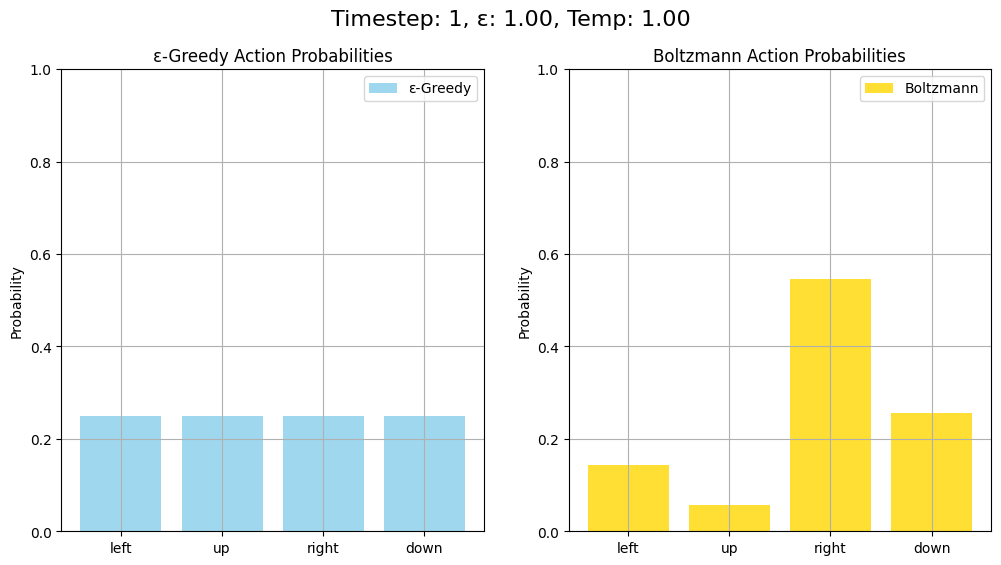

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from maze import Maze
from DQNAgent import DQNAgent
import torch

# Constants
GAME_HEIGHT = 125
GAME_WIDTH = 125
NUMBER_OF_TILES = 9
TILE_SIZE = GAME_HEIGHT // NUMBER_OF_TILES

# Maze layout
level = [
    "XXXXXXXXXXXXX",
    "X           X",
    "X XXX X XXX X",
    "X   X X   X X",
    "XXX X XXX X X",
    "X   X   X   X",
    "X XXX XXX X X",
    "X X   X   X X",
    "X XXX X XXX X",
    "X   X X   X X",
    "XXX XXX XXX X",
    "XP        X X",
    "XXXXXXXXXXXXX",
]

env = Maze(level, goal_pos=(1, 5), MAZE_HEIGHT=GAME_HEIGHT, MAZE_WIDTH=GAME_WIDTH, SIZE=TILE_SIZE)

# Define state and action dimensions
state_dim = 2
action_dim = 4
agent = DQNAgent(state_dim, action_dim)

# Function to calculate ε-greedy probabilities
def calculate_e_greedy_probs(q_values, epsilon):
    num_actions = len(q_values)
    greedy_action = np.argmax(q_values)
    return np.array([epsilon / num_actions if i != greedy_action 
                     else (1 - epsilon) + epsilon / num_actions 
                     for i in range(num_actions)])

# Function to calculate Boltzmann probabilities
def calculate_boltzmann_probs(q_values, temperature):
    q_values_scaled = q_values / temperature
    exp_q = np.exp(q_values_scaled - np.max(q_values_scaled))  # Numerical stability
    return exp_q / np.sum(exp_q)

# Logging Q-values and probabilities during training
num_episodes = 100  # Reduced episodes for faster execution
q_values_over_time = []
epsilon_decay = np.linspace(1.0, 0.1, num_episodes)  # Decaying ε over episodes
temperature_decay = np.linspace(1.0, 0.1, num_episodes)  # Decaying temperature

# Training loop with Q-value logging
for episode in range(num_episodes):
    state = env.reset_state()
    done = False
    epsilon = epsilon_decay[episode]
    temperature = temperature_decay[episode]

    while not done:
        # Get Q-values from the agent
        q_values = agent.q_network(torch.FloatTensor(state).unsqueeze(0)).detach().numpy().flatten()
        
        # Log Q-values only once per episode (when done or at initialization)
        if done or (state == env.get_init_state(level)):  # Log at start or end
            q_values_over_time.append((q_values, epsilon, temperature))
        
        # Perform action selection and training
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        agent.store_transition(state, action, reward, next_state, done)
        agent.train()

        state = next_state  # Update state
    print(f"Episode: {episode}, Epsilon: {epsilon:.2f}, Q-values: {q_values}")


# Create animation for action probabilities
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
action_labels = ["left", "up", "right", "down"]

bars_e_greedy = ax[0].bar(action_labels, [0, 0, 0, 0], color="skyblue", alpha=0.8, label="ε-Greedy")
bars_boltzmann = ax[1].bar(action_labels, [0, 0, 0, 0], color="gold", alpha=0.8, label="Boltzmann")

ax[0].set_ylim(0, 1)
ax[0].set_title("ε-Greedy Action Probabilities")
ax[0].set_ylabel("Probability")
ax[0].legend()
ax[0].grid(True)

ax[1].set_ylim(0, 1)
ax[1].set_title("Boltzmann Action Probabilities")
ax[1].set_ylabel("Probability")
ax[1].legend()
ax[1].grid(True)

# Update function for animation
def update(frame):
    q_values, epsilon, temperature = q_values_over_time[frame]
    e_greedy_probs = calculate_e_greedy_probs(q_values, epsilon)
    boltzmann_probs = calculate_boltzmann_probs(q_values, temperature)

    # Update bar heights
    for bar, prob in zip(bars_e_greedy, e_greedy_probs):
        bar.set_height(prob)
    for bar, prob in zip(bars_boltzmann, boltzmann_probs):
        bar.set_height(prob)

    # Update title
    fig.suptitle(f"Timestep: {frame + 1}, ε: {epsilon:.2f}, Temp: {temperature:.2f}", fontsize=16)

# Create the animation
ani = FuncAnimation(fig, update, frames=len(q_values_over_time), repeat=False, interval=50)

# Save the animation as a GIF
gif_writer = PillowWriter(fps=10)
ani.save("policy_comparison3.gif", writer=gif_writer)

print("Animation saved as 'policy_comparison2.gif'")


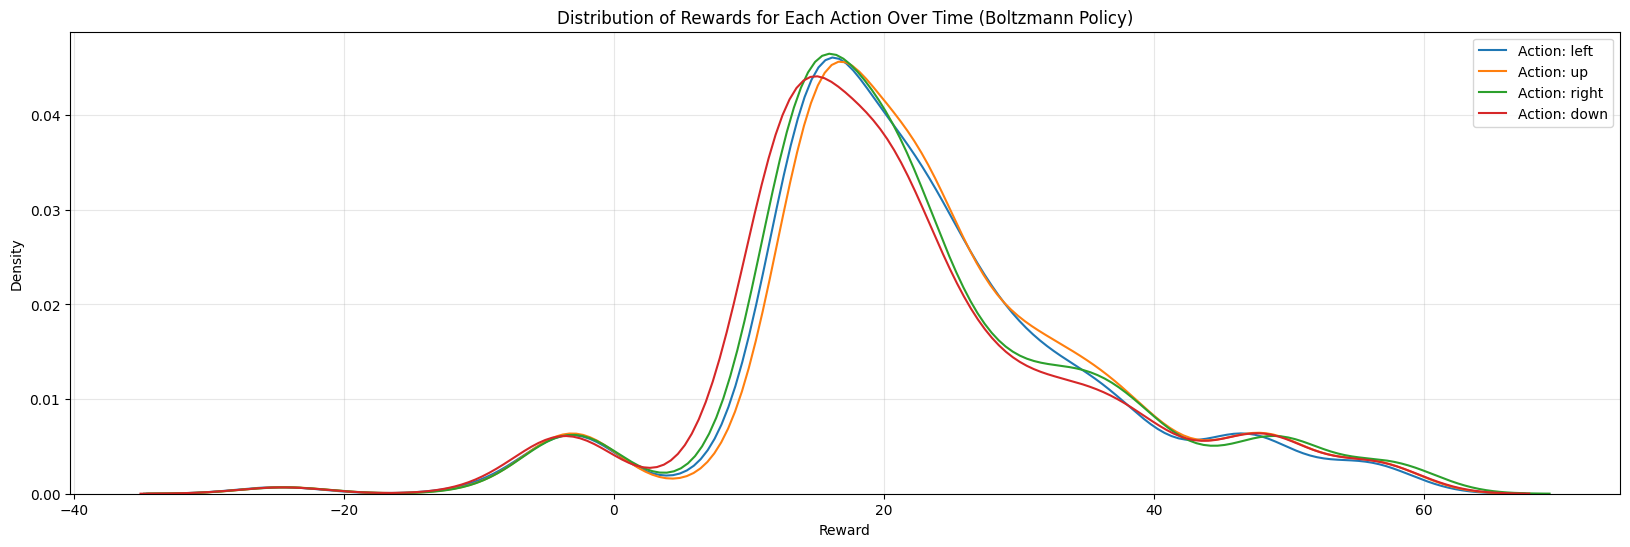

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Actions in the maze
action_labels = ["left", "up", "right", "down"]

# Boltzmann Probability Calculation
def calculate_boltzmann_probs(q_values, temperature):
    q_values_scaled = q_values / temperature
    exp_q = np.exp(q_values_scaled - np.max(q_values_scaled))  # Numerical stability
    return exp_q / np.sum(exp_q)

# Initialize rewards for each action
action_rewards_over_time = {action: [] for action in action_labels}

# Loop through the logged Q-values to compute rewards for each action
for q_values, epsilon, temperature in q_values_over_time:
    boltzmann_probs = calculate_boltzmann_probs(q_values, temperature)

    # Simulate rewards for each action based on Boltzmann probabilities
    for action_index, prob in enumerate(boltzmann_probs):
        # Simulated reward (you can replace this with your actual reward values)
        reward = np.random.normal(loc=q_values[action_index], scale=0.5)  # Simulate reward distribution
        action_rewards_over_time[action_labels[action_index]].append(reward)

# Plot the distribution of rewards for each action over time
plt.figure(figsize=(20, 6))
for action, rewards in action_rewards_over_time.items():
    sns.kdeplot(rewards, label=f'Action: {action}')

plt.xlabel("Reward")
plt.ylabel("Density")
plt.title("Distribution of Rewards for Each Action Over Time (Boltzmann Policy)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


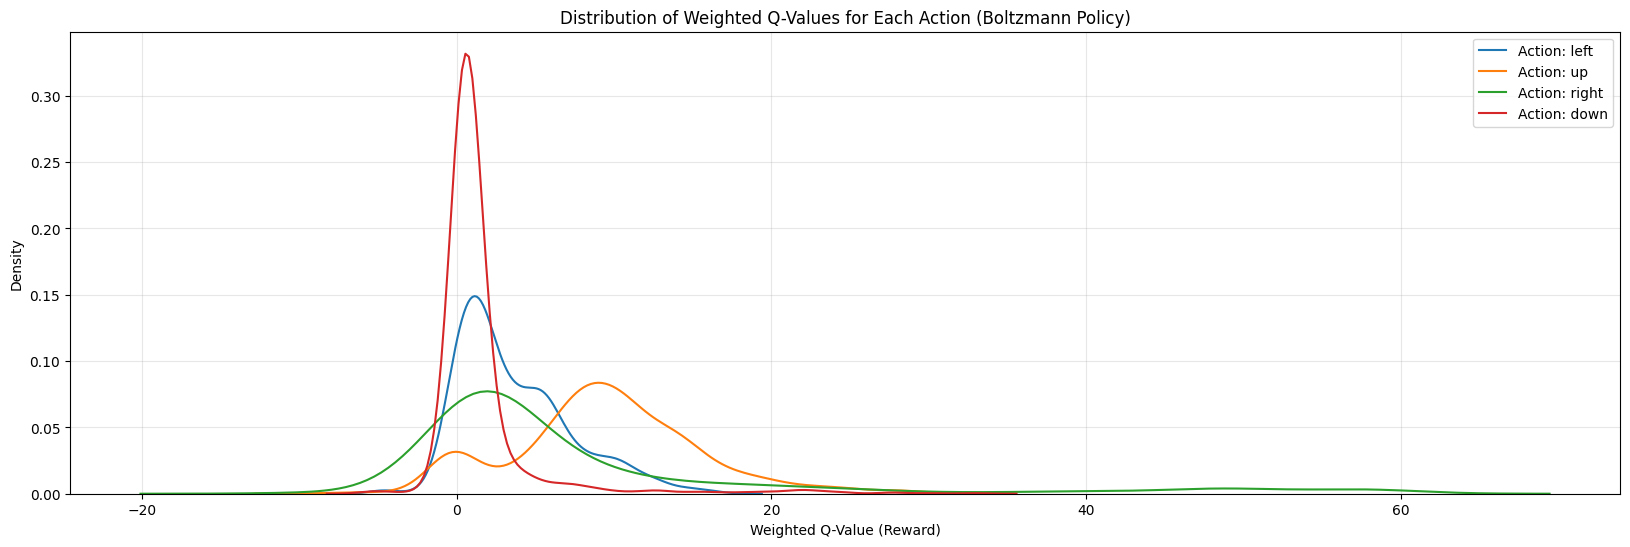

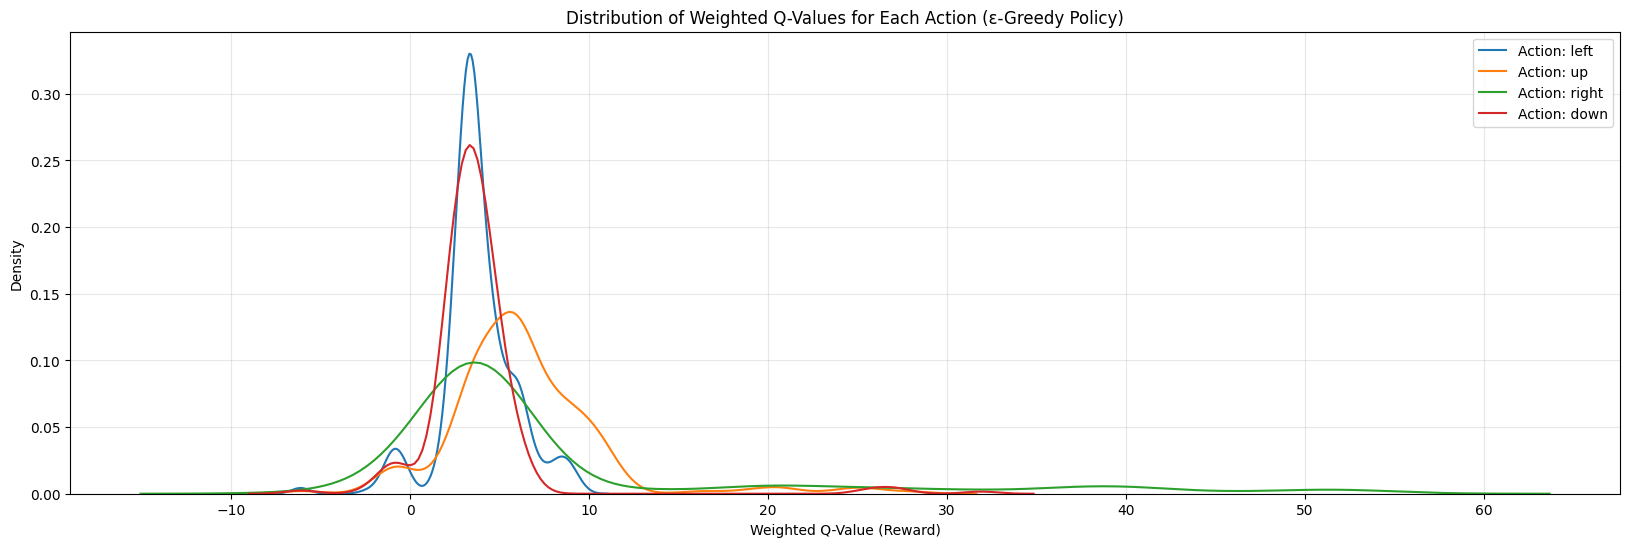

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Actions in the maze
action_labels = ["left", "up", "right", "down"]

# Boltzmann Probability Calculation
def calculate_boltzmann_probs(q_values, temperature):
    q_values_scaled = q_values / temperature
    exp_q = np.exp(q_values_scaled - np.max(q_values_scaled))  # Numerical stability
    return exp_q / np.sum(exp_q)

# ε-Greedy Probability Calculation
def calculate_epsilon_greedy_probs(q_values, epsilon):
    num_actions = len(q_values)
    greedy_action = np.argmax(q_values)  # Action with the highest Q-value
    probs = [epsilon / num_actions] * num_actions  # Exploration probability
    probs[greedy_action] += 1 - epsilon  # Exploitation probability
    return probs

# Initialize rewards for each action under each policy
boltzmann_rewards_over_time = {action: [] for action in action_labels}
epsilon_rewards_over_time = {action: [] for action in action_labels}

# Loop through the logged Q-values to calculate rewards deterministically
for q_values, epsilon, temperature in q_values_over_time:
    # Boltzmann policy
    boltzmann_probs = calculate_boltzmann_probs(q_values, temperature)
    for action_index, prob in enumerate(boltzmann_probs):
        # Use the Q-value as the "reward" for visualization (or actual logged reward if available)
        reward = q_values[action_index] * prob  # Weighted by Boltzmann probability
        boltzmann_rewards_over_time[action_labels[action_index]].append(reward)

    # ε-Greedy policy
    epsilon_probs = calculate_epsilon_greedy_probs(q_values, epsilon)
    for action_index, prob in enumerate(epsilon_probs):
        # Use the Q-value as the "reward" for visualization (or actual logged reward if available)
        reward = q_values[action_index] * prob  # Weighted by ε-greedy probability
        epsilon_rewards_over_time[action_labels[action_index]].append(reward)

# Plot the distributions for Boltzmann policy
plt.figure(figsize=(20, 6))
for action, rewards in boltzmann_rewards_over_time.items():
    sns.kdeplot(rewards, label=f'Action: {action}')
plt.xlabel("Weighted Q-Value (Reward)")
plt.ylabel("Density")
plt.title("Distribution of Weighted Q-Values for Each Action (Boltzmann Policy)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot the distributions for ε-Greedy policy
plt.figure(figsize=(20, 6))
for action, rewards in epsilon_rewards_over_time.items():
    sns.kdeplot(rewards, label=f'Action: {action}')
plt.xlabel("Weighted Q-Value (Reward)")
plt.ylabel("Density")
plt.title("Distribution of Weighted Q-Values for Each Action (ε-Greedy Policy)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


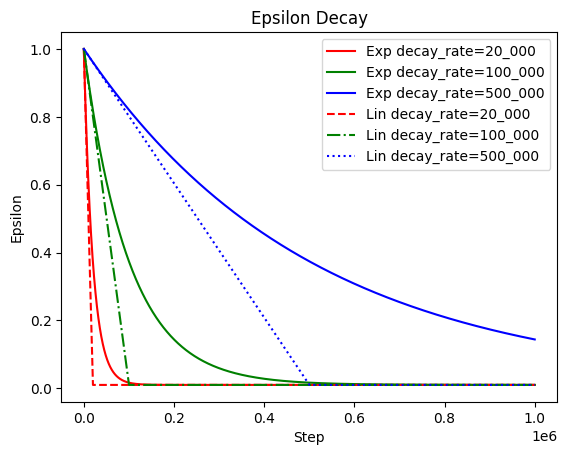

In [ ]:
import math
import matplotlib.pyplot as plt

def exponential_epsilon_decay(step_idx, epsilon_start=1, epsilon_end=0.01, epsilon_decay=100_000):
    """
    Calculates the value of epsilon for a given step index using exponential decay and the specified parameters.

    Parameters:
    step_idx (int): The index of the current step.
    epsilon_start (float): The starting value of epsilon.
    epsilon_end (float): The minimum value of epsilon.
    epsilon_decay (float): The rate at which epsilon decays.

    Returns:
    float: The value of epsilon for the given step index.
    """
    return epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1. * step_idx / epsilon_decay)

def linear_epsilon_decay(step_idx, epsilon_start=1, epsilon_end=0.01, epsilon_decay=100_000):
    """
    Calculates the value of epsilon for a given step index using linear decay and the specified parameters.

    Parameters:
    step_idx (int): The index of the current step.
    epsilon_start (float): The starting value of epsilon.
    epsilon_end (float): The minimum value of epsilon.
    epsilon_decay (float): The total number of steps over which epsilon will decay from epsilon_start to epsilon_end.

    Returns:
    float: The value of epsilon for the given step index.
    """
    return epsilon_end + (epsilon_start - epsilon_end) * max((1 - step_idx / epsilon_decay), 0)

n_steps = 1_000_000
epsilon_decay_rates = [20_000, 100_000, 500_000]

# Calculate epsilon values for each step
exp_epsilon_values = [[exponential_epsilon_decay(step, epsilon_decay=epsilon_decay_rate) for step in range(n_steps)] for epsilon_decay_rate in epsilon_decay_rates]
lin_epsilon_values = [[linear_epsilon_decay(step, epsilon_decay=epsilon_decay_rate) for step in range(n_steps)] for epsilon_decay_rate in epsilon_decay_rates]

# Plot the epsilon decay
plt.plot(exp_epsilon_values[0], 'r-', label='Exp decay_rate=20_000')
plt.plot(exp_epsilon_values[1], 'g-', label='Exp decay_rate=100_000')
plt.plot(exp_epsilon_values[2], 'b-', label='Exp decay_rate=500_000')
plt.plot(lin_epsilon_values[0], 'r--', label='Lin decay_rate=20_000')
plt.plot(lin_epsilon_values[1], 'g-.', label='Lin decay_rate=100_000')
plt.plot(lin_epsilon_values[2], 'b:', label='Lin decay_rate=500_000')
plt.title('Epsilon-greedy Decay')
plt.xlabel('Step')
plt.ylabel('Epsilon')
plt.legend()
plt.show()

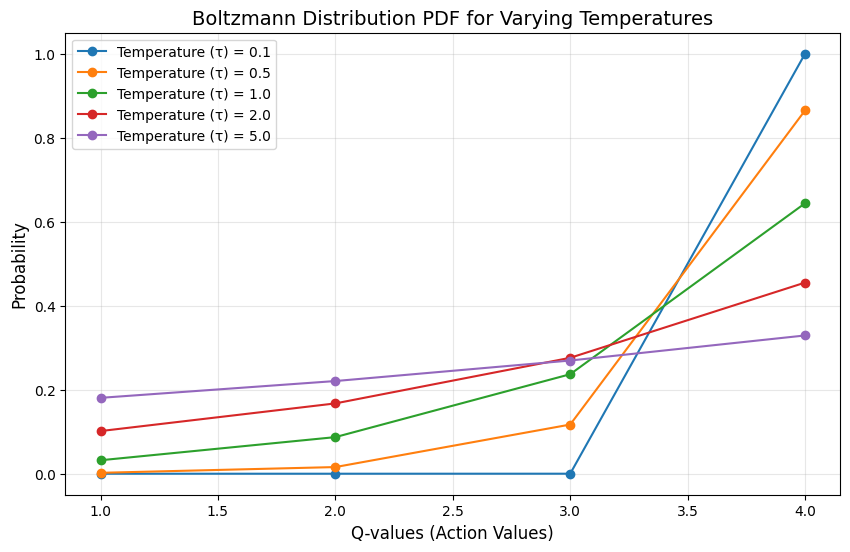

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Boltzmann Probability Calculation
def boltzmann_probs(q_values, temperature):
    q_values_scaled = q_values / temperature
    exp_q = np.exp(q_values_scaled - np.max(q_values_scaled))  # Numerical stability
    return exp_q / np.sum(exp_q)

# Define Q-values (example values for actions)
q_values = np.array([1, 2, 3, 4])

# Range of temperatures to demonstrate exploration-exploitation
temperatures = [0.1, 0.5, 1.0, 2.0, 5.0]

# Plot the Boltzmann probabilities for different temperatures
plt.figure(figsize=(10, 6))

for tau in temperatures:
    probs = boltzmann_probs(q_values, tau)
    plt.plot(q_values, probs, marker='o', label=f'Temperature (τ) = {tau}')

# Add plot details
plt.title("Boltzmann Distribution PDF for Varying Temperatures", fontsize=14)
plt.xlabel("Q-values (Action Values)", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

